<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Формирование-признаков" data-toc-modified-id="Формирование-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Формирование признаков</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Gradient Boosting</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Цель:** с помощью ML-модели спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

**Данные:** временной ряд, каждая строка содержит количество заказов за 1 час. Количество заказов находится в столбце num_orders.  

**Метрика модели:** RMSE (не больше 48).

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

In [3]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
df = df.set_index('datetime').resample('1H').sum()

#display(df.head())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB
None


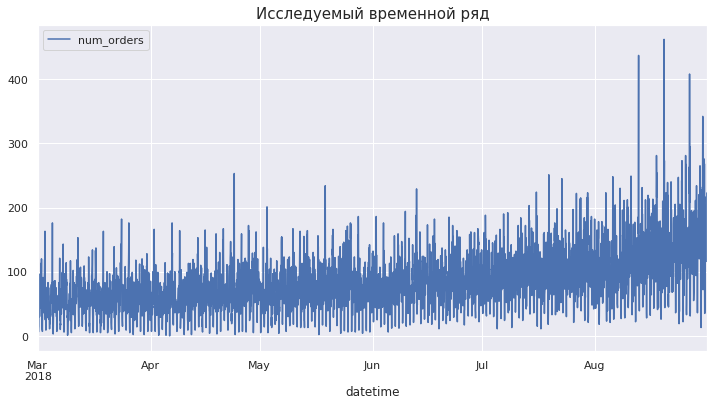

In [4]:
sns.set()
df.plot(figsize=(12,6))
plt.title('Исследуемый временной ряд', fontsize = 15)
plt.show()

На данном этапе во временном ряду можно наблюдать растущий тренд. 

## Анализ

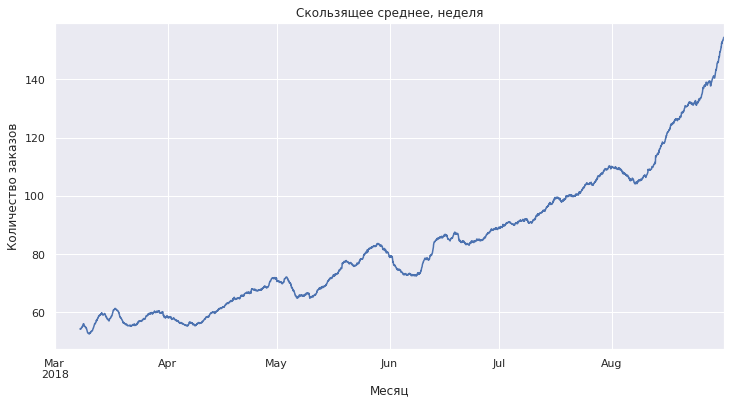

In [5]:
# скользящее среднее за неделю 
df.rolling(168).mean().plot(ax = plt.gca(), figsize=(12, 6), legend = None)
plt.title('Скользящее среднее, неделя')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Скользящее среднее указывает на возрастающий тренд. В исследуемых данных спрос на такси монотонно возрастает к осени.

Данные доступны только с матра по август, но можно предположить, что спрос достигает пика зимой, когда температура на улице некомфортна и пользователи предпочитают вызвать такси. Отсюда можем выдвинуть гипотезу о наличии годовой сезонности. 

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


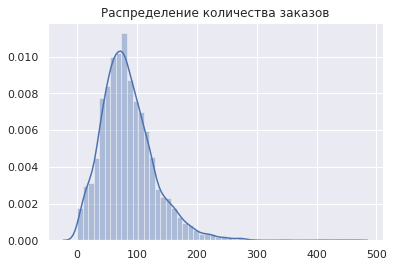

In [6]:
display(df.describe())

sns.set()
sns.distplot(df)
plt.title('Распределение количества заказов')
plt.show()

Распреление колоколообразное, с положительной ассиметрией. Ассиметрия может объясняться восходящим трендом. 

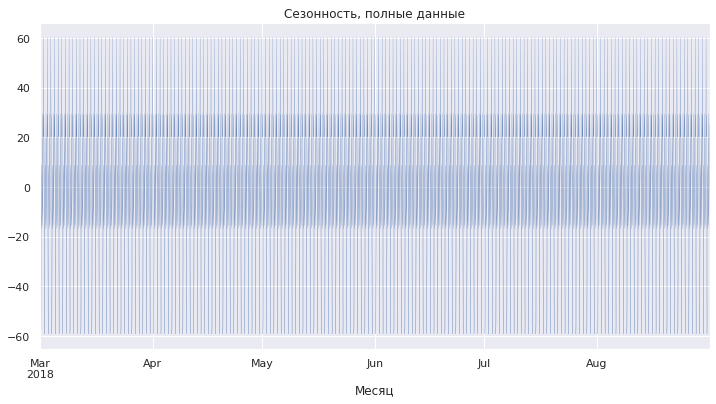

In [7]:
decomposed = seasonal_decompose(df)
decomposed.seasonal.plot(ax=plt.gca(), linewidth=0.2, figsize=(12,6), legend=None)
plt.title('Сезонность, полные данные')
plt.xlabel('Месяц')
plt.show()

На всех данных прослеживается сезонность высокой частоты, изучим ее подробнее на недельном срезе. 

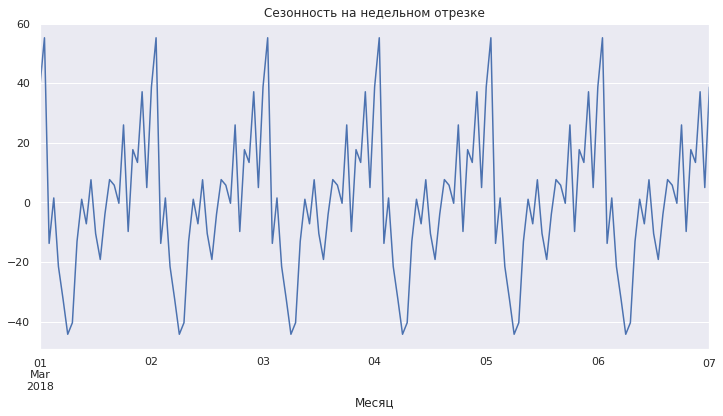

In [8]:
week_df = df['2018-03-01 00:00:00':'2018-03-07 00:00:00']
week_decomposed = seasonal_decompose(week_df)
week_decomposed.seasonal.plot(figsize=(12,6), legend=None)
plt.title('Сезонность на недельном отрезке')
plt.xlabel('Месяц')
plt.show()

Наблюдается дневная сезонность - спрос на такси возрастает к полуночи и спадает к утру. 

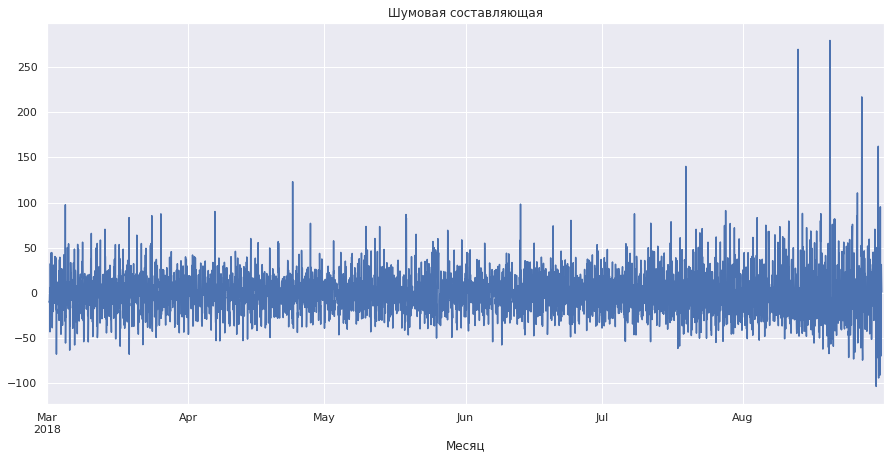

In [9]:
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 7), legend = None)
plt.title('Шумовая составляющая')
plt.xlabel('Месяц')
plt.show()

Шумовая составляющая не имеет явной структуры. 

Так как ранее было выявлено наличие тренда и сезонности, с большой вероятностью исследуемый ряд нестационарен.
Проведем обощенный тест Дикки-Фуллера. 

In [10]:
test = sm.tsa.adfuller(df['num_orders'])
print('p-value:', test[1])
print('Критическое значение 5%:', test[4]['5%'])
if test[1] > test[4]['5%']: 
    print('Ряд нестационарен')
else:
    print('Ряд стационарен.')

p-value: 0.028940051402612906
Критическое значение 5%: -2.8621993540813637
Ряд нестационарен


**Вывод:** исследуемый ряд нестационарен. 

### Формирование признаков 

Признаки формируются на основании: 
- компонетов timestamps (месяц, день, день недели, час); 
- временных лагов (подбор максимального лага осуществляется по метрикам обучаемых моделей);
- скользящего среднего (скользящее окно осуществляется по метрикам обучаемых моделей). 

In [11]:
def make_features(max_lag, rolling_mean_size, data=df):
    '''
    Creates features 
    '''
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    return data

In [12]:
def data_split(data):
    '''
    Splits data into train&test sets 
    '''
    X = data.drop('num_orders', axis = 1)
    y = data['num_orders']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    
    return X_train, X_test, X_cv, y_cv, y_train, y_test

## Обучение и тестирование

***Примечание:*** анализ результатов моделей будет проводиться в выводе. 

In [13]:
def model_fitting(max_lag, rolling_mean_size, estimator): 
    '''
    Fits the model, returns predictions & true labels. 
    
    Used functions: 
    - make_features
    - data_split
    '''
    data = make_features(max_lag, rolling_mean_size)
    X_train, X_test, X_cv, y_cv, y_train, y_test = data_split(data)
    
    model = estimator.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_cv = model.predict(X_cv)
        
    return model, predictions_train, predictions_cv, y_train, y_cv, X_test, y_test

In [14]:
def test(predictions_train, predictions_cv, y_train, y_cv):
    '''
    Returns RMSE on train&test sets
    '''
    rmse_train =  mean_squared_error(y_train, predictions_train)**0.5
    rmse_cv = mean_squared_error(y_cv, predictions_cv)**0.5
    return rmse_train, rmse_cv

In [15]:
def model_tuning(lag_size_min, lag_size_max, rolling_mean_min, rolling_mean_max, estimator): 
    '''
    Selects the best combination of the following features: 
    - lag_size
    - rolling_mean 
    
    Used functions: 
    - model_fitting
    '''
    rmse_cv_min = 10000
    for i in range(lag_size_min, lag_size_max): 
        for j in range(rolling_mean_min, rolling_mean_max):
            model, pred_train, pred_cv, y_train, y_cv, X_test, y_test = model_fitting(i, j, estimator)
            
            rmse_train, rmse_cv = test(pred_train, pred_cv, y_train, y_cv)
            if rmse_cv < rmse_cv_min: 
                rmse_cv_min = rmse_cv
                best_lag_size = i
                best_rolling_mean = j
    return rmse_cv_min, best_lag_size, best_rolling_mean

In [16]:
def plot(pred_train, pred_cv, pred_test, rolling_size):
    ser_pred_train = pd.Series(pred_train, index= y_train.index)
    ser_pred_cv = pd.Series(pred_cv, index = y_cv.index)
    ser_pred_test = pd.Series(pred_test, index = y_test.index)

    ser_pred_train.rolling(rolling_size).mean().plot(linewidth = 0.8, figsize=(15, 8))
    y_train.rolling(rolling_size).mean().plot(linewidth = 0.8, figsize=(15, 8))
   
    ser_pred_cv.rolling(rolling_size).mean().plot(linewidth = 0.8, figsize=(15, 8))
    y_cv.rolling(rolling_size).mean().plot(linewidth = 0.8, figsize=(15, 8))
    
    ser_pred_test.rolling(rolling_size).mean().plot(linewidth = 0.8, figsize=(15, 8))
    y_test.rolling(rolling_size).mean().plot(linewidth = 0.8, figsize=(15, 8))
    
    
    plt.title('Предсказания модели, скользящее среднее за неделю', fontsize=15)
    plt.ylabel('Количество заказов')
    plt.xlabel('Месяц')
    plt.legend(labels=['predictions, train', 'true, train',  
                       'predictions, cv', 'true, cv', 
                       'predictions, test', 'true, test',])
    plt.show()

### Linear Regression

In [17]:
# перебор параметров осуществлялся в другой тетради, диапазон, переданный функции - наиболее удачный   
rmse_cv_min, best_lag_size, best_rolling_mean = model_tuning(201, 203, 204, 206, LinearRegression())
print('RMSE тестовая выборка:', rmse_cv_min)
print('Best lag size:',best_lag_size)
print('Best rolling mean:', best_rolling_mean) 

RMSE тестовая выборка: 27.414292415281565
Best lag size: 202
Best rolling mean: 205


In [18]:
linreg, pred_train, pred_cv, y_train, y_cv, X_test, y_test = model_fitting(202, 205, LinearRegression())
rmse_train, rmse_cv = test(pred_train, pred_cv, y_train, y_cv)
print('Метрики полученной модели')
print('RMSE train:', rmse_train)
print('RMSE cv:', rmse_cv)

Метрики полученной модели
RMSE train: 18.38460243841443
RMSE cv: 27.414292415281565


In [19]:
def test_rmse(model, X_test): 
    pred_test = model.predict(X_test)
    print('RMSE test:', mean_squared_error(y_test, pred_test)**0.5)
    return pred_test

In [20]:
pred_test = test_rmse(linreg, X_test)

RMSE test: 38.69897367568692


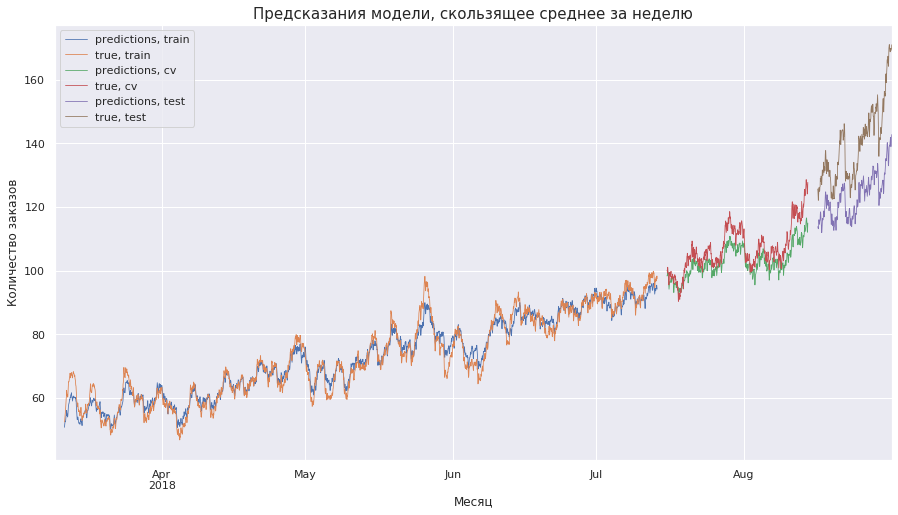

In [21]:
plot(pred_train, pred_cv, pred_test, 50)

### Random Forest 

In [22]:
forest, pred_train, pred_cv, y_train, y_cv, X_test, y_test = model_fitting(160, 210, RandomForestRegressor(random_state=42))
rmse_train, rmse_cv = test(pred_train, pred_cv, y_train, y_cv)
print('RMSE train:', rmse_train)
print('RMSE cv:', rmse_cv)

RMSE train: 9.06290197486857
RMSE cv: 32.054712350663074


In [23]:
# сетка, по которой изначально проводлся перебор гиперпараметров
#grid = {'bootstrap': [True, False],
#        'max_depth': [10, 30, 50, 70, None],
#        'max_features': ['auto', 'sqrt'],
#        'min_samples_leaf': [1, 2, 4],
#        'min_samples_split': [2, 5, 10],
#        'n_estimators': [150, 200]}

grid = {'n_estimators': [200], 
        'min_samples_split': [5], 
        'min_samples_leaf': [4], 
        'max_features': ['auto'], 
        'max_depth': [10], 
        'bootstrap': [True]}

In [24]:
data = make_features(160, 210)
X_train, X_test, X_cv, y_cv, y_train, y_test = data_split(data)

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

random = RandomizedSearchCV(RandomForestRegressor(random_state=42), grid, random_state=42, 
                            scoring='neg_mean_squared_error', n_iter=1, cv=tscv)
random.fit(X_train, y_train)
print(random.best_params_)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


In [26]:
# сетка, по которой изначально проводлся перебор гиперпараметров
#grid = {'bootstrap': [True],
#        'max_depth': [8, 10, 12],
#        'max_features': ['auto'],
#        'min_samples_leaf': [3, 4],
#        'min_samples_split': [4, 5],
#        'n_estimators': [200]}

grid = {'bootstrap': [True],
        'max_depth': [12],
        'max_features': ['auto'],
        'min_samples_leaf': [4],
        'min_samples_split': [4],
        'n_estimators': [200]}

In [27]:
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=grid, 
                    scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)
forest_best = grid.best_params_
print('Best RMSE, cv:', abs(grid.best_score_)**0.5)

Best RMSE, cv: 22.474033692999296


In [28]:
forest, pred_train, pred_cv, y_train, y_cv, X_test, y_test = model_fitting(160, 210, 
                                                                           RandomForestRegressor(**forest_best,
                                                                                                 random_state=42))
rmse_train, rmse_cv = test(pred_train, pred_cv, y_train, y_cv)
print('RMSE train:', rmse_train)
print('RMSE cv:', rmse_cv)

RMSE train: 10.528929239842205
RMSE cv: 31.25885804359545


In [29]:
pred_test = test_rmse(forest, X_test)

RMSE test: 53.23354787040707


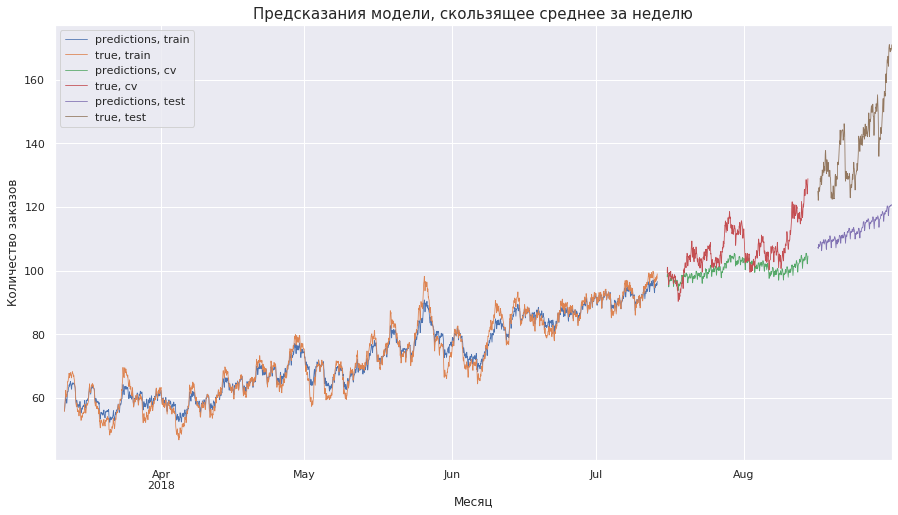

In [30]:
plot(pred_train, pred_cv, pred_test, 50)

### Gradient Boosting 

Настройка гиперпараметров

In [31]:
boosting, pred_train, pred_cv, y_train, y_cv, X_test, y_test = model_fitting(250, 300, 
                                                                         GradientBoostingRegressor(random_state=42))
rmse_train, rmse_test = test(pred_train, pred_cv, y_train, y_cv)
print('RMSE train:', rmse_train)
print('RMSE test:', rmse_test)

RMSE train: 15.290378760018259
RMSE test: 29.079140048089016


In [32]:
pred_test = test_rmse(boosting, X_test)

RMSE test: 45.789527081787064


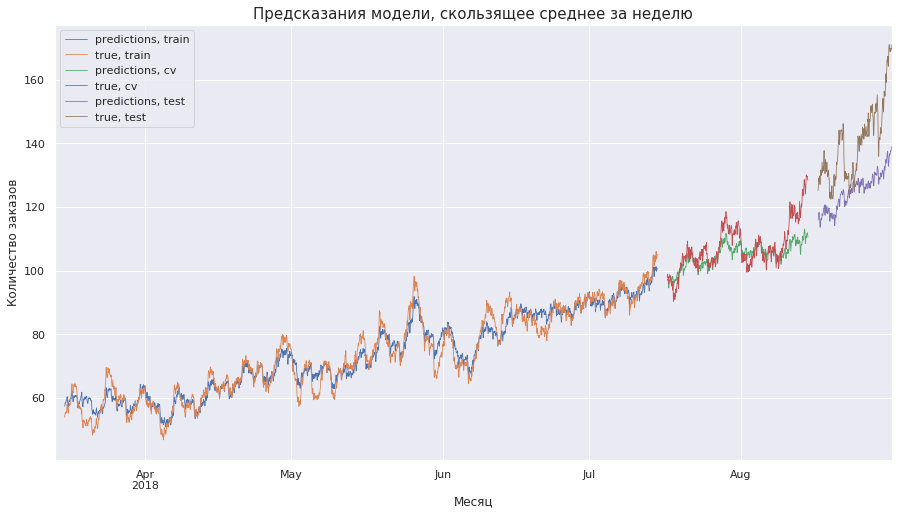

In [33]:
plot(pred_train, pred_cv, pred_test, 50)

## Вывод 

Линейная регрессия показала лучший результат.
Во всех трех моделях наблюдается резкое ухудшение метрики на кросс-валидации и тесте. Может быть связано с тем, что модели не учитывают рост скорости изменения тренда. 

Возможно, это связано с тем, что обучающая выборка была сокращена за счет валидационной, поэтому модель не учитывает возрастание тренда. Протестируем модели, обученные на увеличенной обучающей выборке. 

In [34]:
def train_cv_concat(max_lag, rolling_mean_size, df=df): 
    data = make_features(max_lag, rolling_mean_size, data=df)
    X_train, X_test, X_cv, y_cv, y_train, y_test = data_split(data) 
    X_train = pd.concat([X_train, X_cv]) 
    y_train = pd.concat([y_train, y_cv]) 

    return X_train, y_train, X_test, y_test

In [35]:
def new_model_test(max_lag, rolling_mean_size, estimator): 
    '''
    Uses train_cv_concat function
    '''
    X_train, y_train, X_test, y_test = train_cv_concat(max_lag, rolling_mean_size)
    model = estimator.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    print('RMSE test:', mean_squared_error(y_train, predictions_train)**0.5)
    print('RMSE train:', mean_squared_error(y_test, predictions_test)**0.5)  

In [36]:
print('Линейная регрессия')
new_model_test(202, 205, linreg)

print('Случайный лес')
new_model_test(160, 210, forest)

print('Градиентный бустинг')
new_model_test(250, 300, boosting)

Линейная регрессия
RMSE test: 20.16782135407612
RMSE train: 35.43901445078884
Случайный лес
RMSE test: 11.839622454543827
RMSE train: 39.555356249342196
Градиентный бустинг
RMSE test: 16.673509747563354
RMSE train: 37.47664493294638


Обучение на увеличенной выборке повысило качество модели. Можно предположить, что чем больше размер валидационной выборки, тем хуже модель различает тренд в данных. 